In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import keras

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.pkl.gz')
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
x_train = x_train[:10000]

In [4]:
#my tips:Gauss sampling,sample Z
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


#my tips:loss(restruct X)+KL
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [5]:
batch_size = 100
original_dim = 784   #28*28
latent_dim = 2
intermediate_dim = 200
nb_epoch = 300
epsilon_std = 1.0

In [6]:
#my tips:encoding
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

W0224 09:04:02.676844 11356 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0224 09:04:02.720818 11356 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0224 09:04:02.729813 11356 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [7]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# my tips:get sample z(encoded)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
 
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

W0224 09:04:02.796871 11356 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [8]:
#This model will include all layers required in the computation of x given x_decoded_mean.
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.99, beta_2=0.999, amsgrad=False)
vae = Model(x, x_decoded_mean)
vae.compile(optimizer=adam, loss=vae_loss)

W0224 09:04:02.906289 11356 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0224 09:04:02.921281 11356 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0224 09:04:02.941272 11356 deprecation.py:323] From C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
# train the VAE on MNIST digits
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        verbose=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 10000 samples, validate on 10000 samples
Epoch 1/300
 - 2s - loss: 208.4971 - val_loss: 186.8704
Epoch 2/300
 - 2s - loss: 181.7789 - val_loss: 177.5931
Epoch 3/300
 - 2s - loss: 174.5934 - val_loss: 172.7668
Epoch 4/300
 - 2s - loss: 170.1346 - val_loss: 169.8143
Epoch 5/300
 - 1s - loss: 167.3948 - val_loss: 167.9085
Epoch 6/300
 - 1s - loss: 165.5706 - val_loss: 166.5759
Epoch 7/300
 - 1s - loss: 164.4384 - val_loss: 165.5784
Epoch 8/300
 - 1s - loss: 163.3672 - val_loss: 165.3610
Epoch 9/300
 - 1s - loss: 162.7571 - val_loss: 164.6711
Epoch 10/300
 - 1s - loss: 162.1560 - val_loss: 164.2803
Epoch 11/300
 - 1s - loss: 161.7827 - val_loss: 164.5283
Epoch 12/300
 - 1s - loss: 161.4441 - val_loss: 163.6752
Epoch 13/300
 - 1s - loss: 161.0555 - val_loss: 162.6717
Epoch 14/300
 - 1s - loss: 160.4931 - val_loss: 162.9165
Epoch 15/300
 - 1s - loss: 159.9345 - val_loss: 162.2636
Epoch 16/300
 - 1s - loss: 159.4068 - val_loss: 161.8082
Epoch 17/300
 - 1s - loss: 159.1730 - val_loss:

Epoch 144/300
 - 2s - loss: 148.6618 - val_loss: 158.6948
Epoch 145/300
 - 2s - loss: 148.5092 - val_loss: 158.8006
Epoch 146/300
 - 2s - loss: 147.8878 - val_loss: 158.6437
Epoch 147/300
 - 2s - loss: 148.2350 - val_loss: 158.7008
Epoch 148/300
 - 2s - loss: 148.5226 - val_loss: 158.9344
Epoch 149/300
 - 2s - loss: 148.9359 - val_loss: 160.1944
Epoch 150/300
 - 2s - loss: 149.0143 - val_loss: 159.6754
Epoch 151/300
 - 2s - loss: 148.8018 - val_loss: 159.0574
Epoch 152/300
 - 2s - loss: 148.5537 - val_loss: 158.9751
Epoch 153/300
 - 2s - loss: 148.3272 - val_loss: 158.6826
Epoch 154/300
 - 2s - loss: 148.2457 - val_loss: 159.1197
Epoch 155/300
 - 2s - loss: 148.2675 - val_loss: 158.6255
Epoch 156/300
 - 2s - loss: 148.5076 - val_loss: 159.4771
Epoch 157/300
 - 2s - loss: 148.5073 - val_loss: 158.9252
Epoch 158/300
 - 2s - loss: 148.2670 - val_loss: 159.1365
Epoch 159/300
 - 2s - loss: 148.7011 - val_loss: 159.5345
Epoch 160/300
 - 2s - loss: 149.2480 - val_loss: 159.8807
Epoch 161/300


Epoch 286/300
 - 2s - loss: 146.8498 - val_loss: 159.9211
Epoch 287/300
 - 2s - loss: 146.7935 - val_loss: 160.1887
Epoch 288/300
 - 2s - loss: 146.6598 - val_loss: 160.2157
Epoch 289/300
 - 2s - loss: 146.9737 - val_loss: 160.2196
Epoch 290/300
 - 2s - loss: 146.8518 - val_loss: 159.6418
Epoch 291/300
 - 2s - loss: 147.4210 - val_loss: 160.3059
Epoch 292/300
 - 2s - loss: 147.0817 - val_loss: 160.1789
Epoch 293/300
 - 2s - loss: 147.3355 - val_loss: 160.9365
Epoch 294/300
 - 2s - loss: 147.9792 - val_loss: 160.8465
Epoch 295/300
 - 2s - loss: 147.6936 - val_loss: 160.4549
Epoch 296/300
 - 2s - loss: 147.3293 - val_loss: 159.9851
Epoch 297/300
 - 2s - loss: 147.3051 - val_loss: 159.8146
Epoch 298/300
 - 2s - loss: 147.4253 - val_loss: 160.5809
Epoch 299/300
 - 2s - loss: 147.5944 - val_loss: 161.1742
Epoch 300/300
 - 2s - loss: 147.3487 - val_loss: 160.4857


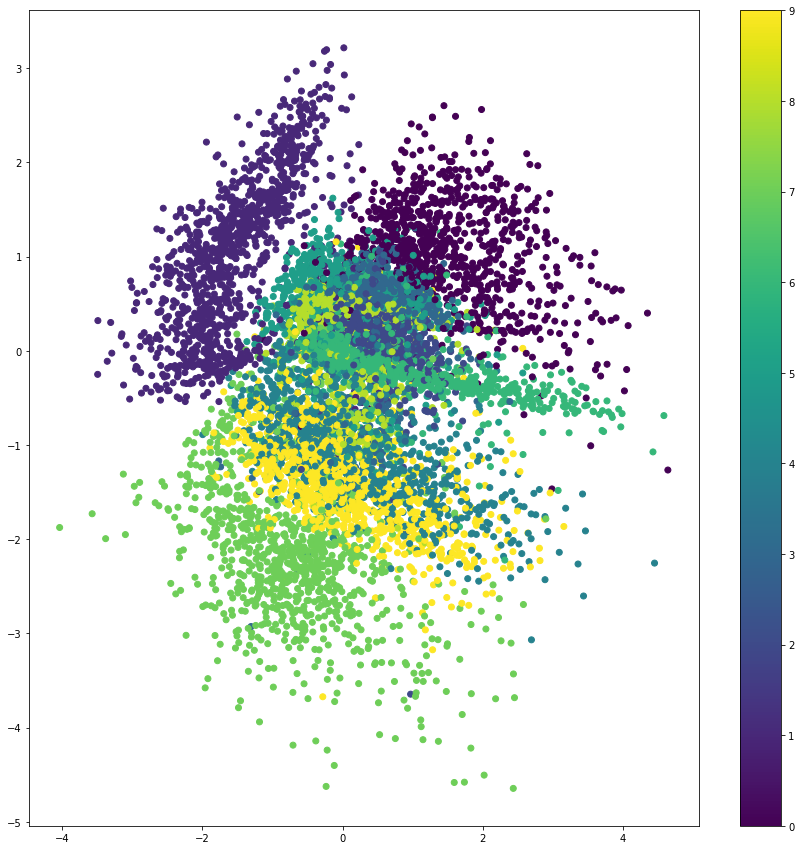

In [10]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
 
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(15,15))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
 
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

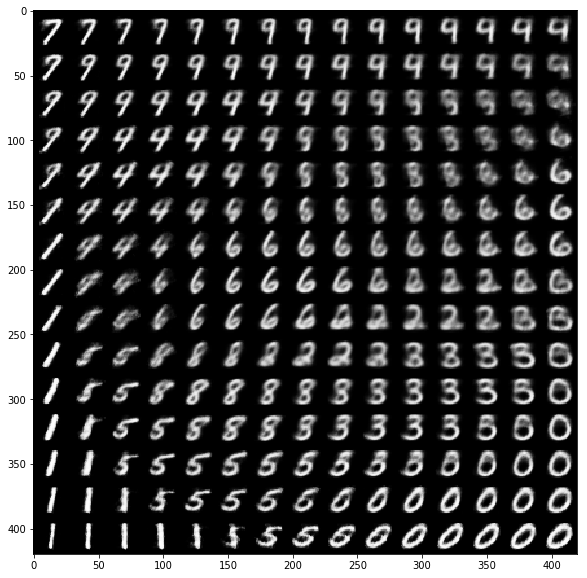

In [11]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        
 
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [12]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        print(yi)

-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.6448536269514729
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-1.204046960026702
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.920822976368379
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.697141434846342
-0.6971414348463